In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Set random seed for reproducibility
np.random.seed(42)

def generate_gmm_data(n_samples=1000):
    """
    Generate data from a mixture of 3 Gaussians in 2D space.
    The data is deliberately shaped to be challenging for K-means.
    """
    # Mixture weights
    weights = [0.3, 0.4, 0.3]

    # Component means
    means = [
        np.array([-5, 0]),    # Cluster 1
        np.array([5, 0]),     # Cluster 2
        np.array([0, 7]),     # Cluster 3
    ]

    # Component covariances (varied shapes to challenge K-means)
    covs = [
        np.array([[4, 2.5], [2.5, 4]]),      # Elongated, tilted
        np.array([[3, -1], [-2, 3]]),        # Elongated, tilted opposite direction
        np.array([[1, 0], [0, 1]])           # Circular
    ]

    # Generate samples
    X = np.zeros((n_samples, 2))
    labels_true = np.zeros(n_samples, dtype=int)

    # Generate data for each component
    count = 0
    for i in range(len(weights)):
        n_comp_samples = int(weights[i] * n_samples)
        comp_samples = np.random.multivariate_normal(means[i], covs[i], size=n_comp_samples)
        X[count:count+n_comp_samples] = comp_samples
        labels_true[count:count+n_comp_samples] = i
        count += n_comp_samples

    # Fill any remaining samples due to rounding
    if count < n_samples:
        remaining = n_samples - count
        comp_samples = np.random.multivariate_normal(means[0], covs[0], size=remaining)
        X[count:] = comp_samples
        labels_true[count:] = 0

    return X, labels_true

def plot_data(X, title="Generated Data"):
    """Plot the raw data points"""
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_kmeans_clusters(X, kmeans):
    """Plot K-means clustering results"""
    plt.figure(figsize=(10, 6))

    # Plot points colored by cluster
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)

    # Plot cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')

    plt.title("K-means Clustering Results")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_confidence_ellipse(ax, mean, cov, color, alpha=0.3):
    """
    Plot an ellipse representing a 2D Gaussian distribution with given mean and covariance.
    """
    # Calculate eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Get angle of largest eigenvector with x-axis
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

    # Width and height are 2 std deviations (95% confidence)
    width, height = 2 * np.sqrt(2.0 * eigenvals)

    # Create ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor=color, alpha=alpha)

    ax.add_patch(ellipse)
    return ellipse


C:\Users\AT Once\AppData\Local\Temp\ipykernel_12144\3291826184.py:40: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  comp_samples = np.random.multivariate_normal(means[i], covs[i], size=n_comp_samples)


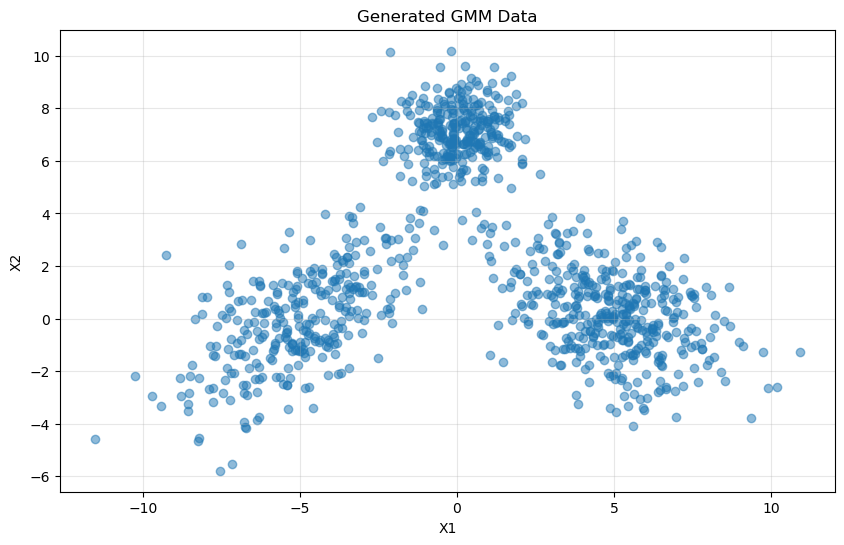

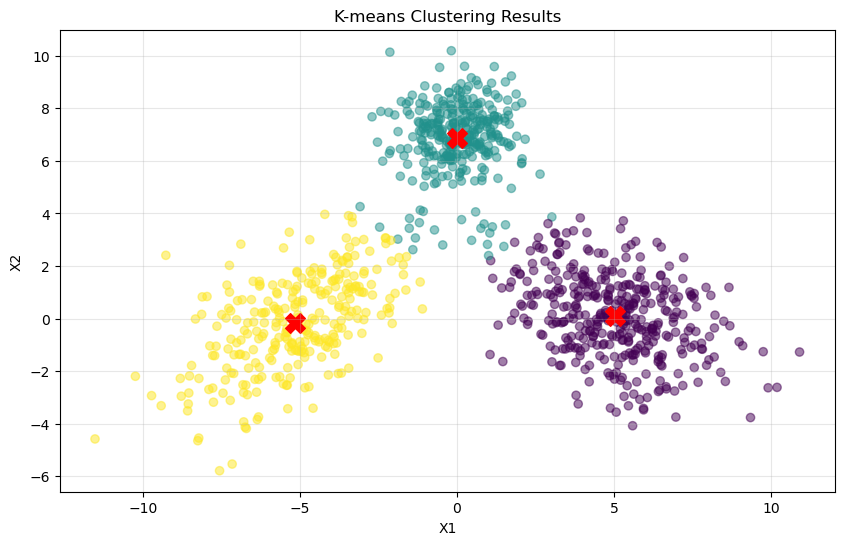

In [3]:
    # Generate data from a Gaussian mixture
    X, true_labels = generate_gmm_data(n_samples=1000)

    # Plot original data
    plot_data(X, title="Generated GMM Data")

    # Apply K-means
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans.fit(X)
    plot_kmeans_clusters(X, kmeans)

In [ ]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [18]:
class GMM:
    """
    Gaussian Mixture Model implementation using Expectation-Maximization algorithm.
    """
    def __init__(self, n_components, max_iter=100, tol=1e-4, random_state=None):
        """
        Initialize GMM parameters.

        Parameters:
        -----------
        n_components : int
            Number of Gaussian components
        max_iter : int
            Maximum number of EM iterations
        tol : float
            Convergence tolerance
        random_state : int
            Random seed for reproducibility
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        # To be initialized during fitting
        self.weights = None      # Mixture weights
        self.means = None        # Component means
        self.covs = None         # Component covariances
        self.labels = None       # Cluster assignments
        self.responsibilities = None  # Soft assignments

    def _initialize_parameters(self, X):
        """Initialize model parameters using K-means for better starting points or use random intialization if you want
        Model Parameters are mean vector and covarience matrix per each component (cluster) """
        n_samples, n_features = X.shape

        # Use K-means for initialization
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        kmeans.fit(X)

        # Set initial means to K-means cluster centers
        self.means = kmeans.cluster_centers_

        # Set uniform weights
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize covariances using cluster assignments
        self.covs = np.zeros((self.n_components, n_features, n_features))
        self.labels = kmeans.labels_

        for k in range(self.n_components):
            cluster_points = X[self.labels == k]
            if len(cluster_points) > 0:
                self.covs[k] = np.cov(cluster_points.T) + np.eye(n_features) * 0.01  # Add small regularization
            else:
                self.covs[k] = np.eye(n_features)  # Fallback if empty cluster

    def _multivariate_gaussian(self, X, mean, cov):
        """
        Calculate multivariate Gaussian density for each sample.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Data points
        mean : array-like of shape (n_features,)
            Mean of Gaussian component
        cov : array-like of shape (n_features, n_features)
            Covariance matrix of Gaussian component

        Returns:
        --------
        densities : array-like of shape (n_samples,)
            Density for each sample
        """
        n_features = X.shape[1]
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        # Avoid numerical issues with small/negative determinants
        if det <= 0:
            cov = cov + np.eye(n_features) * 0.01
            det = np.linalg.det(cov)
            inv = np.linalg.inv(cov)
        # complete the function to return density for each data point
        N=(1.0 / (np.power(2 * np.pi, n_features / 2) * np.sqrt(det)))* np.exp(-0.5 * np.sum((X - mean) @ inv * (X - mean), axis=1))
        print(N.shape)
        return N

    def _expectation_step(self, X):
      """
      E-step: Calculate responsibilities (posterior probabilities) and log-likelihood.

      Parameters:
      -----------
      X : array-like of shape (n_samples, n_features)
          Input data

      Returns:
      --------
      log_likelihood : float
          Log-likelihood of the data under the current model
      """
      n_samples = X.shape[0]
      weighted_densities = np.zeros((n_samples, self.n_components))

      # Compute weighted Gaussian densities for all components
      for k in range(self.n_components):
          density = self._multivariate_gaussian(X, self.means[k], self.covs[k])
          weighted_densities[:, k] = self.weights[k] * density

      # Compute responsibilities (posterior probabilities)
      total_density = np.sum(weighted_densities, axis=1, keepdims=True)
      self.responsibilities = weighted_densities / total_density

      # Avoid NaNs in case of division by zero
      self.responsibilities = np.nan_to_num(self.responsibilities, nan=1.0/self.n_components)

      # Compute log-likelihood
      log_likelihood = np.sum(np.log(total_density))

      return log_likelihood


    def _maximization_step(self, X):
        """
        M-step: Update parameters (weights, means, covariances)

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Input data
        """
        n_samples, n_features = X.shape
        Nk=np.sum(self.responsibilities,axis=0)
        self.weights=Nk/n_samples
        self.means = (self.responsibilities.T @ X) / Nk.reshape(-1, 1)
        
        for k in range(self.n_components):
            diff = X - self.means[k]  
            res = self.responsibilities[:, k]  
            cov_k = (res[:, np.newaxis] * diff).T @ diff / Nk[k]
            self.covs[k] = cov_k + np.eye(n_features) * 1e-6

    def fit(self, X):
        """
        Fit the GMM to the data using EM algorithm.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data

        Returns:
        --------
        self : object
            Fitted estimator
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Initialize parameters
        self._initialize_parameters(X)

        # EM iterations
        log_likelihood_old = -np.inf

        for iteration in range(self.max_iter):
            # E-step
            log_likelihood = self._expectation_step(X)

            # M-step
            self._maximization_step(X)

            # Check convergence
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break

            log_likelihood_old = log_likelihood

        # Assign cluster labels (hard assignments)
        self.labels = np.argmax(self.responsibilities, axis=1)

        return self

    def predict(self, X):
        """
        Predict cluster labels for given data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data

        Returns:
        --------
        labels : array-like of shape (n_samples,)
            Cluster labels
        """
        # Calculate responsibilities for new data
        n_samples = X.shape[0]
        weighted_densities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            densities = self._multivariate_gaussian(X, self.means[k], self.covs[k])
            weighted_densities[:, k] = self.weights[k] * densities

        # Return most likely component for each sample
        return np.argmax(weighted_densities, axis=1)

    def predict_proba(self, X):
        """
        Predict posterior probabilities of cluster labels for given data.

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            New data

        Returns:
        --------
        responsibilities : array-like of shape (n_samples, n_components)
            Posterior probabilities of each component for each sample
        """
        n_samples = X.shape[0]
        weighted_densities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            densities = self._multivariate_gaussian(X, self.means[k], self.covs[k])
            weighted_densities[:, k] = self.weights[k] * densities

        # Normalize to get responsibilities
        total_density = np.sum(weighted_densities, axis=1, keepdims=True)
        responsibilities = weighted_densities / total_density

        return responsibilities

def plot_gmm_results(X, gmm, title="GMM Clustering Results"):
    """Plot GMM clustering results with confidence ellipses"""
    plt.figure(figsize=(10, 6))

    # Plot points colored by cluster
    plt.scatter(X[:, 0], X[:, 1], c=gmm.labels, cmap='viridis', alpha=0.5)

    # Plot cluster centers
    plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X')

    # Plot confidence ellipses for each component
    ax = plt.gca()
    colors = plt.cm.viridis(np.linspace(0, 1, gmm.n_components))

    for i, (mean, cov, color) in enumerate(zip(gmm.means, gmm.covs, colors)):
        plot_confidence_ellipse(ax, mean, cov, color)

    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_kmeans_gmm(X, n_clusters=3):
    """Compare K-means and GMM on the same dataset"""
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)

    # GMM clustering
    gmm = GMM(n_components=n_clusters, random_state=42)
    gmm.fit(X)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot K-means results
    ax1.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                c='red', s=200, marker='X')
    ax1.set_title("K-means Clustering")
    ax1.set_xlabel("X1")
    ax1.set_ylabel("X2")
    ax1.grid(True, alpha=0.3)

    # Plot GMM results
    ax2.scatter(X[:, 0], X[:, 1], c=gmm.labels, cmap='viridis', alpha=0.5)
    ax2.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X')

    # Add confidence ellipses
    colors = plt.cm.viridis(np.linspace(0, 1, gmm.n_components))
    for i, (mean, cov, color) in enumerate(zip(gmm.means, gmm.covs, colors)):
        plot_confidence_ellipse(ax2, mean, cov, color)

    ax2.set_title("GMM Clustering")
    ax2.set_xlabel("X1")
    ax2.set_ylabel("X2")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


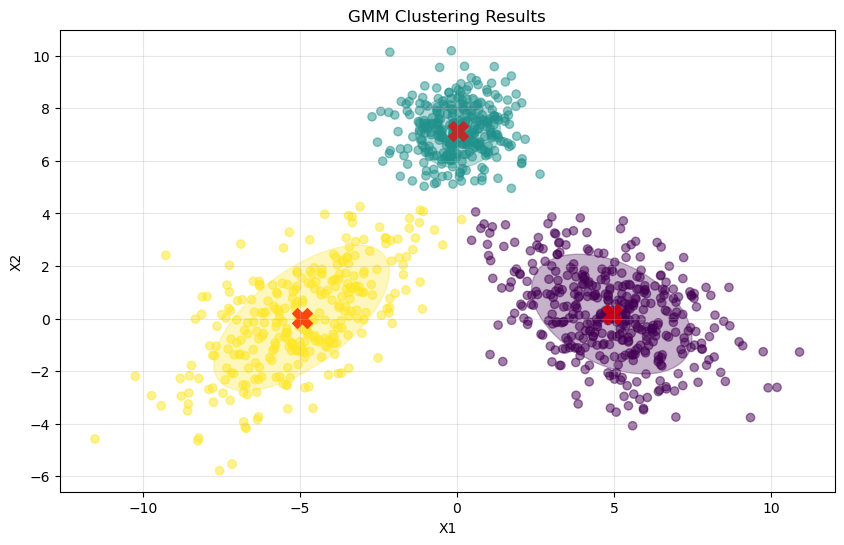

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


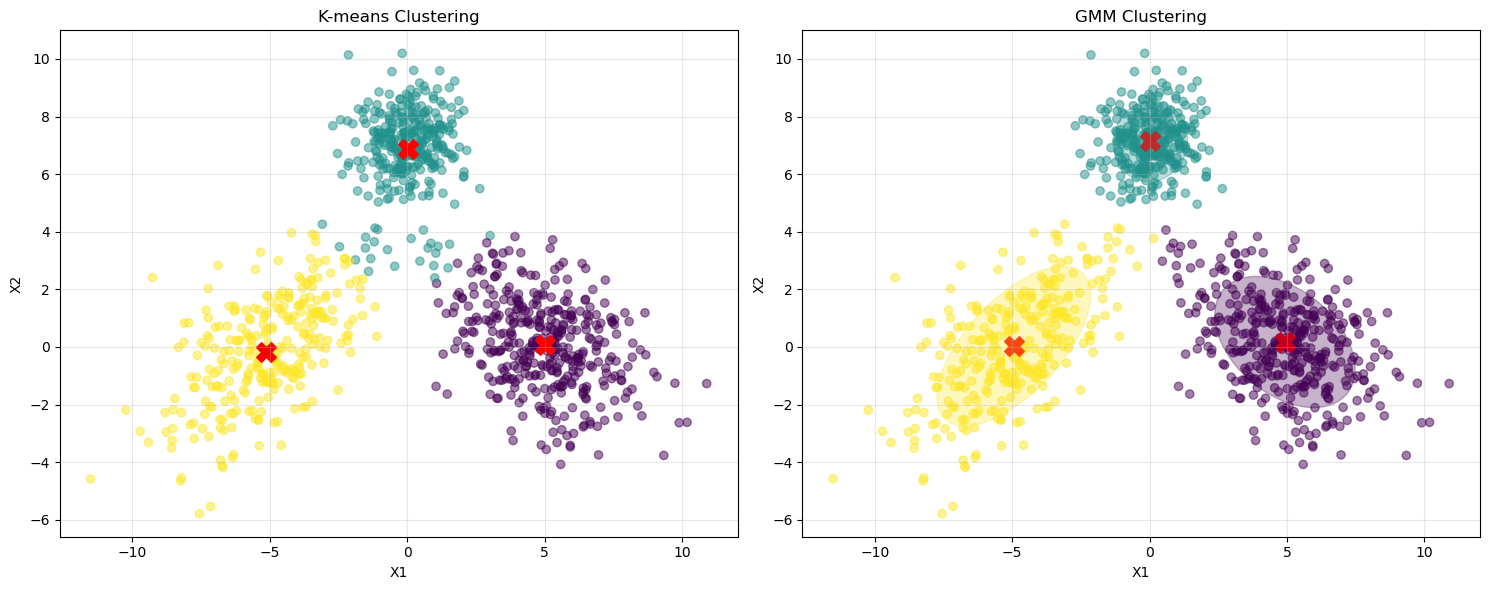

In [19]:
# Apply GMM
gmm = GMM(n_components=3, random_state=42)
gmm.fit(X)
plot_gmm_results(X, gmm)

# Direct comparison
compare_kmeans_gmm(X, n_clusters=3)